# Define Library

In [1]:

# %% [markdown]
# # Jupyter Notebook Loading Header
#
# This is a custom loading header for Jupyter Notebooks in Visual Studio Code.
# It includes common imports and settings to get you started quickly.
# %% [markdown]
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.cloud import storage
import os
import tempfile
import time
from datetime import datetime
import uuid
import joblib
import uuid
from sklearn.metrics import roc_auc_score
from datetime import datetime, timedelta
import gcsfs
import duckdb as dd
import pickle
import joblib
from typing import Union
import io
path = r'C:\Users\Dwaipayan\AppData\Roaming\gcloud\legacy_credentials\dchakroborti@tonikbank.com\adc.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = bigquery.Client(project='prj-prod-dataplatform')
os.environ["GOOGLE_CLOUD_PROJECT"] = "prj-prod-dataplatform"
# %% [markdown]
## Configure Settings
# Set options or configurations as needed
pd.set_option('display.max_columns', None)
pd.set_option("Display.max_rows", 100)


# Query for New Customer OOP Score

In [11]:
sq = """
with b1 as (
  select t1.employee_id, 
  user_timelines.first_account_activated_at as ee_onboarding_date,
  t1.run_date,
  t1.attrition_model_name,
  t1.ee_attrition_feature,
  t1.ee_attrition_risk_segment,
  t1.ee_attrition_time_to_leave,
  t1.oop_model_name,
  t1.oop_feature,
  t1.oop_score,
  t1.oop_risk_segment,
  from prj-prod-dataplatform.tendo_mart.tendo_scorecard_master_table t1
  left join tendopay_raw.user_timelines on cast(user_timelines.user_id as string) = cast(t1.employee_id as string)
  where date(user_timelines.first_account_activated_at) < '2025-06-01'
  -- and date(t1.run_date) >= '2025-01-06' and  date(t1.run_date) <= '2025-07-31'  
  qualify row_number() over(partition by t1.employee_id order by t1.run_date) = 1
),
b2 as (
  select distinct employee_id, run_date, oop_score
  from prj-prod-dataplatform.tendo_mart.tendo_scorecard_master_table
  where date(run_date) >= '2025-06-01'
  -- where format_date('%Y-%m', date(run_date)) in ('2025-06', '2027-07')
  -- union all
  -- select distinct employee_id, run_date, oop_score
  -- from prj-prod-dataplatform.tendo_mart.tendo_scorecard_master_table
  -- where date(run_date) >= date('2025-01-06') and  date(run_date) <= date('2025-07-31')  
),
b3 as (
  select
    b1.employee_id,
    date(b1.ee_onboarding_date) ee_onboarding_date,
    format_date('%Y-%m', date(b1.ee_onboarding_date)) onboarding_month,
    date(b2.run_date) run_date,
    format_date('%Y-%m', date(b2.run_date)) score_month,
    abs(date_diff(date(b2.run_date), date(b1.ee_onboarding_date), day)) as ddiff,
    b1.oop_score,
    b2.oop_score b2oopscore,
    b1.oop_risk_segment
  from b1
  inner join b2 on b2.employee_id = b1.employee_id  -- Use INNER JOIN if you only want matches
)
select b3.*, b4.target, b4.target_maturity_flag
from b3
left join prj-prod-dataplatform.tendo_mart.tendo_collection_target_master b4 on b4.user_id = b3.employee_id
where b4.target_maturity_flag = 1
qualify row_number() over(partition by b3.employee_id order by b3.ddiff) = 1
order by ee_onboarding_date;
"""
dfd = client.query(sq).to_dataframe(progress_bar_type='tqdm')
print(f"The shape of the dataframe is: {dfd.shape}")
dfd.head()

Job ID 6d2def2c-b53b-4272-ab2b-b00a1332fcb6 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The shape of the dataframe is: (2872, 11)


,employee_id,ee_onboarding_date,onboarding_month,run_date,score_month,ddiff,oop_score,b2oopscore,oop_risk_segment,target,target_maturity_flag
0,126130,2020-08-07,2020-08,2025-06-07,2025-06,1765,0.563862,0.563862,A,0,1
1,127748,2020-08-12,2020-08,2025-06-12,2025-06,1765,0.562241,0.562241,A,0,1
2,216229,2020-12-15,2020-12,2025-07-15,2025-07,1673,0.513384,0.513384,B,1,1
3,228551,2021-01-06,2021-01,2025-07-06,2025-07,1642,0.480085,0.480085,C,0,1
4,228702,2021-01-06,2021-01,2025-07-06,2025-07,1642,0.477173,0.477173,D,0,1


In [12]:
dfd.groupby('onboarding_month').agg({'employee_id':'nunique'})

,employee_id
onboarding_month,
2020-08,2
2020-12,1
2021-01,4
2021-03,5
2021-04,5
2021-05,2
2021-06,3
2021-07,2
2021-08,28


In [13]:
dfd.groupby('score_month').agg({'employee_id':'nunique'})

,employee_id
score_month,
2025-06,1520
2025-07,1237
2025-08,56
2025-09,7
2025-10,32
2025-11,13
2025-12,3
2026-01,4


# Gini Calculation

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

def calculate_gini(y_true, y_pred):
    """
    Calculate Gini coefficient from actual values and predicted scores.
    Gini = 2 * AUC - 1
    """
    auc = roc_auc_score(y_true, y_pred)
    gini = 2 * auc - 1
    return gini

def gini_by_group(df, score_col, target_col, group_col):
    """
    Calculate Gini coefficient for each group.
    """
    gini_results = {}
    for group in df[group_col].unique():
        group_data = df[df[group_col] == group]
        if len(group_data) > 0 and group_data[target_col].nunique() > 1:
            gini = calculate_gini(group_data[target_col], group_data[score_col])
            gini_results[group] = gini
        else:
            gini_results[group] = np.nan
    return gini_results

def calculate_bad_metrics(df, target_col, maturity_flag_col):
    """
    Calculate count of bad and percentage of bad.
    Bad = target / target_maturity_flag
    """
    count_bad = (df[target_col] / df[maturity_flag_col]).sum()
    total_count = len(df)
    pct_bad = (count_bad / total_count * 100) if total_count > 0 else 0
    return count_bad, pct_bad

def bad_metrics_by_group(df, target_col, maturity_flag_col, group_col):
    """
    Calculate bad metrics for each group.
    """
    bad_results = {'count_bad': {}, 'pct_bad': {}}
    for group in df[group_col].unique():
        group_data = df[df[group_col] == group]
        if len(group_data) > 0:
            count_bad, pct_bad = calculate_bad_metrics(group_data, target_col, maturity_flag_col)
            bad_results['count_bad'][group] = count_bad
            bad_results['pct_bad'][group] = pct_bad
    return bad_results

def combined_gini(df, score_cols, target_col):
    """
    Calculate combined Gini for multiple score columns.
    Uses average of normalized scores as combined score.
    """
    # Normalize scores to [0, 1] range
    normalized_scores = pd.DataFrame()
    for col in score_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            normalized_scores[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            normalized_scores[col] = 0
    
    # Combined score is average of normalized scores
    combined_score = normalized_scores.mean(axis=1)
    combined_gini_val = calculate_gini(df[target_col], combined_score)
    
    return combined_gini_val

# Load your data
df = dfd.copy()  # Replace with your actual data file

print("=" * 90)
print("GINI COEFFICIENT ANALYSIS WITH BAD METRICS")
print("=" * 90)

# Calculate overall bad metrics
overall_count_bad, overall_pct_bad = calculate_bad_metrics(df, 'target', 'target_maturity_flag')
print(f"\nOVERALL BAD METRICS:")
print(f"  Count of Bad: {overall_count_bad:.2f}")
print(f"  Percentage of Bad: {overall_pct_bad:.2f}%")

# 1. Gini by onboarding_month
print("\n1. GINI BY ONBOARDING_MONTH")
print("-" * 90)
gini_onboarding_oop = gini_by_group(df, 'oop_score', 'target', 'onboarding_month')
gini_onboarding_b2oop = gini_by_group(df, 'b2oopscore', 'target', 'onboarding_month')
bad_onboarding = bad_metrics_by_group(df, 'target', 'target_maturity_flag', 'onboarding_month')

for month in sorted(gini_onboarding_oop.keys()):
    print(f"Month: {month}")
    print(f"  OOP Score Gini:     {gini_onboarding_oop[month]:.6f}")
    print(f"  B2OOP Score Gini:   {gini_onboarding_b2oop[month]:.6f}")
    print(f"  Count of Bad:       {bad_onboarding['count_bad'][month]:.2f}")
    print(f"  Percentage of Bad:  {bad_onboarding['pct_bad'][month]:.2f}%")
    print()

# 2. Gini by score_month
print("\n2. GINI BY SCORE_MONTH")
print("-" * 90)
gini_score_oop = gini_by_group(df, 'oop_score', 'target', 'score_month')
gini_score_b2oop = gini_by_group(df, 'b2oopscore', 'target', 'score_month')
bad_score = bad_metrics_by_group(df, 'target', 'target_maturity_flag', 'score_month')

for month in sorted(gini_score_oop.keys()):
    print(f"Month: {month}")
    print(f"  OOP Score Gini:     {gini_score_oop[month]:.6f}")
    print(f"  B2OOP Score Gini:   {gini_score_b2oop[month]:.6f}")
    print(f"  Count of Bad:       {bad_score['count_bad'][month]:.2f}")
    print(f"  Percentage of Bad:  {bad_score['pct_bad'][month]:.2f}%")
    print()

# 3. Overall Gini (combined for entire dataset)
print("\n3. OVERALL GINI (ENTIRE DATASET)")
print("-" * 90)
overall_gini_oop = calculate_gini(df['target'], df['oop_score'])
overall_gini_b2oop = calculate_gini(df['target'], df['b2oopscore'])
overall_combined_gini = combined_gini(df, ['oop_score', 'b2oopscore'], 'target')

print(f"OOP Score Gini:           {overall_gini_oop:.6f}")
print(f"B2OOP Score Gini:         {overall_gini_b2oop:.6f}")
print(f"Combined Gini:            {overall_combined_gini:.6f}")
print()

# 4. Create summary DataFrame for export
print("\n4. SUMMARY TABLES")
print("-" * 90)

# Summary by onboarding_month
summary_onboarding = pd.DataFrame({
    'onboarding_month': list(gini_onboarding_oop.keys()),
    'oop_score_gini': list(gini_onboarding_oop.values()),
    'b2oopscore_gini': list(gini_onboarding_b2oop.values()),
    'count_bad': list(bad_onboarding['count_bad'].values()),
    'pct_bad': list(bad_onboarding['pct_bad'].values())
})
summary_onboarding['combined_gini'] = summary_onboarding['onboarding_month'].apply(
    lambda m: combined_gini(df[df['onboarding_month'] == m], ['oop_score', 'b2oopscore'], 'target')
    if len(df[df['onboarding_month'] == m]) > 0 and df[df['onboarding_month'] == m]['target'].nunique() > 1
    else np.nan
)
print("\nONBOARDING MONTH SUMMARY:")
print(summary_onboarding.to_string(index=False))

# Summary by score_month
summary_score = pd.DataFrame({
    'score_month': list(gini_score_oop.keys()),
    'oop_score_gini': list(gini_score_oop.values()),
    'b2oopscore_gini': list(gini_score_b2oop.values()),
    'count_bad': list(bad_score['count_bad'].values()),
    'pct_bad': list(bad_score['pct_bad'].values())
})
summary_score['combined_gini'] = summary_score['score_month'].apply(
    lambda m: combined_gini(df[df['score_month'] == m], ['oop_score', 'b2oopscore'], 'target')
    if len(df[df['score_month'] == m]) > 0 and df[df['score_month'] == m]['target'].nunique() > 1
    else np.nan
)
print("\nSCORE MONTH SUMMARY:")
print(summary_score.to_string(index=False))

# Export to Excel
with pd.ExcelWriter('gini_analysis_results.xlsx', engine='openpyxl') as writer:
    summary_onboarding.to_excel(writer, sheet_name='Gini by Onboarding Month', index=False)
    summary_score.to_excel(writer, sheet_name='Gini by Score Month', index=False)
    
    # Overall summary
    overall_summary = pd.DataFrame({
        'Metric': ['OOP Score Gini', 'B2OOP Score Gini', 'Combined Gini', 'Count of Bad', 'Percentage of Bad'],
        'Value': [overall_gini_oop, overall_gini_b2oop, overall_combined_gini, overall_count_bad, overall_pct_bad]
    })
    overall_summary.to_excel(writer, sheet_name='Overall Summary', index=False)

print("\n✓ Results exported to 'gini_analysis_results.xlsx'")

GINI COEFFICIENT ANALYSIS WITH BAD METRICS

OVERALL BAD METRICS:
  Count of Bad: 814.00
  Percentage of Bad: 28.34%

1. GINI BY ONBOARDING_MONTH
------------------------------------------------------------------------------------------
Month: 2020-08
  OOP Score Gini:     nan
  B2OOP Score Gini:   nan
  Count of Bad:       0.00
  Percentage of Bad:  0.00%

Month: 2020-12
  OOP Score Gini:     nan
  B2OOP Score Gini:   nan
  Count of Bad:       1.00
  Percentage of Bad:  100.00%

Month: 2021-01
  OOP Score Gini:     nan
  B2OOP Score Gini:   nan
  Count of Bad:       0.00
  Percentage of Bad:  0.00%

Month: 2021-03
  OOP Score Gini:     0.333333
  B2OOP Score Gini:   0.333333
  Count of Bad:       3.00
  Percentage of Bad:  60.00%

Month: 2021-04
  OOP Score Gini:     1.000000
  B2OOP Score Gini:   1.000000
  Count of Bad:       1.00
  Percentage of Bad:  20.00%

Month: 2021-05
  OOP Score Gini:     -1.000000
  B2OOP Score Gini:   -1.000000
  Count of Bad:       1.00
  Percentage of Bad

# Gini Calculation with Analysis

COMPREHENSIVE GINI COEFFICIENT ANALYSIS WITH BAD METRICS

1. INDIVIDUAL SCORE GINI (OVERALL)
----------------------------------------------------------------------------------------------------
OOP Score Gini:        0.285015
B2OOP Score Gini:      0.286890

2. OVERALL BAD METRICS
----------------------------------------------------------------------------------------------------
Count of Bad:          814.00
Percentage of Bad:     28.34%

3. COMBINED GINI (OVERALL)
----------------------------------------------------------------------------------------------------
Combined Gini (Mean):   0.285976
Combined Gini (Median): 0.285976
Combined Gini (Weighted): 0.285975

4. DETAILED GINI SUMMARY BY GROUPS
----------------------------------------------------------------------------------------------------
onboarding_month  Sample_Size  oop_score_Gini  oop_score_AUC  b2oopscore_Gini  b2oopscore_AUC  Combined_Gini  Count_Bad   Pct_Bad score_month
         2021-03            5        0.333333   

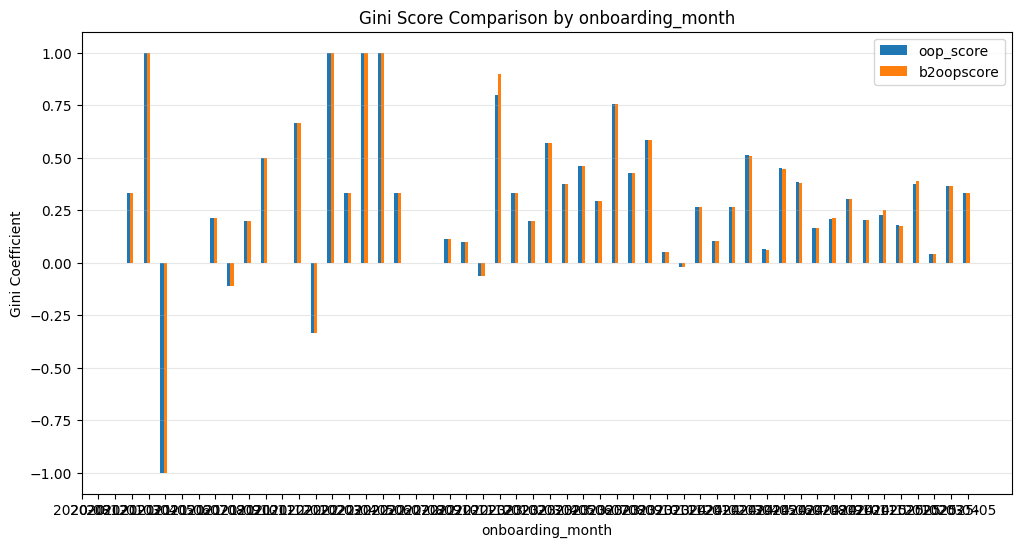

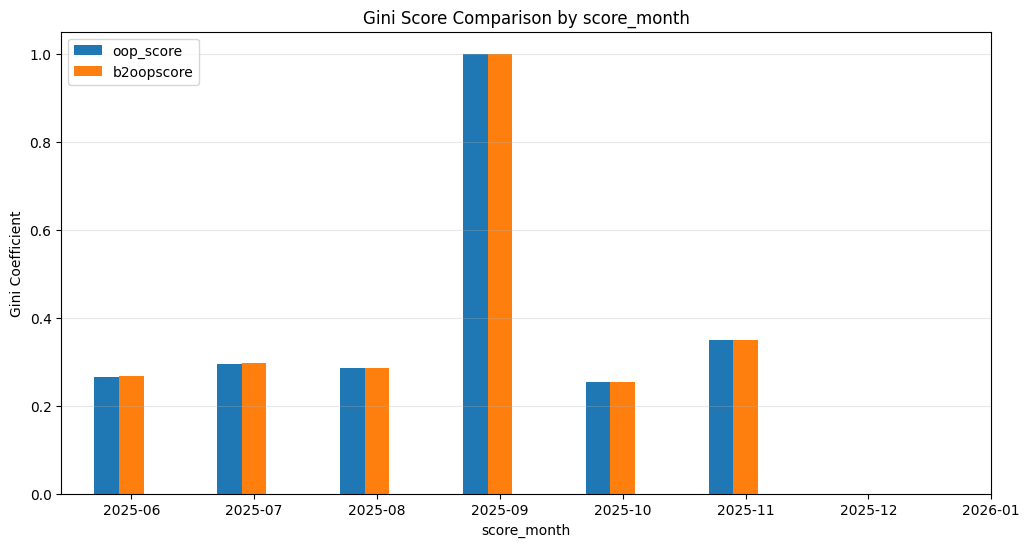

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

class GiniAnalyzer:
    """
    Comprehensive Gini coefficient analysis for predictive scores.
    """
    
    def __init__(self, df, target_col='target', maturity_flag_col='target_maturity_flag'):
        self.df = df.copy()
        self.target_col = target_col
        self.maturity_flag_col = maturity_flag_col
    
    def calculate_gini(self, y_true, y_pred):
        """Gini coefficient: 2*AUC - 1"""
        if y_true.nunique() < 2:
            return np.nan
        auc = roc_auc_score(y_true, y_pred)
        return 2 * auc - 1
    
    def calculate_bad_metrics(self, data=None):
        """Calculate count and percentage of bad"""
        if data is None:
            data = self.df
        count_bad = (data[self.target_col] / data[self.maturity_flag_col]).sum()
        total_count = len(data)
        pct_bad = (count_bad / total_count * 100) if total_count > 0 else 0
        return count_bad, pct_bad
    
    def gini_by_score(self, score_col, group_col=None):
        """Calculate Gini for score column, optionally grouped"""
        if group_col:
            results = {}
            for group in self.df[group_col].unique():
                group_data = self.df[self.df[group_col] == group]
                gini = self.calculate_gini(group_data[self.target_col], group_data[score_col])
                results[group] = gini
            return pd.Series(results)
        else:
            return self.calculate_gini(self.df[self.target_col], self.df[score_col])
    
    def combined_gini(self, score_cols, group_col=None, method='mean'):
        """
        Calculate combined Gini from multiple scores.
        method: 'mean', 'median', 'weighted'
        """
        def get_combined_score(data):
            normalized = pd.DataFrame()
            for col in score_cols:
                min_val = data[col].min()
                max_val = data[col].max()
                if max_val > min_val:
                    normalized[col] = (data[col] - min_val) / (max_val - min_val)
                else:
                    normalized[col] = 0
            
            if method == 'mean':
                return normalized.mean(axis=1)
            elif method == 'median':
                return normalized.median(axis=1)
            elif method == 'weighted':
                # Weight by individual Gini scores
                weights = []
                for col in score_cols:
                    gini = self.calculate_gini(data[self.target_col], data[col])
                    weights.append(max(gini, 0) + 1)
                weights = np.array(weights) / sum(weights)
                return (normalized * weights).sum(axis=1)
        
        if group_col:
            results = {}
            for group in self.df[group_col].unique():
                group_data = self.df[self.df[group_col] == group]
                combined_score = get_combined_score(group_data)
                gini = self.calculate_gini(group_data[self.target_col], combined_score)
                results[group] = gini
            return pd.Series(results)
        else:
            combined_score = get_combined_score(self.df)
            return self.calculate_gini(self.df[self.target_col], combined_score)
    
    def gini_summary(self, score_cols, group_cols):
        """Generate comprehensive Gini summary with bad metrics"""
        results = []
        
        for group_col in group_cols:
            for group_val in sorted(self.df[group_col].unique()):
                group_data = self.df[self.df[group_col] == group_val]
                if len(group_data) == 0 or group_data[self.target_col].nunique() < 2:
                    continue
                
                row = {group_col: group_val, 'Sample_Size': len(group_data)}
                
                for score_col in score_cols:
                    gini = self.calculate_gini(group_data[self.target_col], group_data[score_col])
                    row[f'{score_col}_Gini'] = gini
                    row[f'{score_col}_AUC'] = (gini + 1) / 2
                
                # Combined Gini
                combined = self.combined_gini(score_cols, group_col=group_col)
                row['Combined_Gini'] = combined.get(group_val, np.nan)
                
                # Bad metrics
                count_bad, pct_bad = self.calculate_bad_metrics(group_data)
                row['Count_Bad'] = count_bad
                row['Pct_Bad'] = pct_bad
                
                results.append(row)
        
        return pd.DataFrame(results)
    
    def plot_gini_comparison(self, score_cols, group_col, save_path=None):
        """Visualize Gini scores by group"""
        fig, ax = plt.subplots(figsize=(12, 6))
        
        x = np.arange(len(self.df[group_col].unique()))
        width = 0.2
        
        for i, score_col in enumerate(score_cols):
            gini_vals = self.gini_by_score(score_col, group_col)
            ax.bar(x + i*width, gini_vals.values, width, label=score_col)
        
        ax.set_xlabel(group_col)
        ax.set_ylabel('Gini Coefficient')
        ax.set_title(f'Gini Score Comparison by {group_col}')
        ax.set_xticks(x + width)
        ax.set_xticklabels(sorted(self.df[group_col].unique()))
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        return fig


# Usage Example
if __name__ == "__main__":
    # Load data
    df = dfd.copy()
    
    analyzer = GiniAnalyzer(df, target_col='target', maturity_flag_col='target_maturity_flag')
    
    print("=" * 100)
    print("COMPREHENSIVE GINI COEFFICIENT ANALYSIS WITH BAD METRICS")
    print("=" * 100)
    
    # 1. Individual score Gini
    print("\n1. INDIVIDUAL SCORE GINI (OVERALL)")
    print("-" * 100)
    print(f"OOP Score Gini:        {analyzer.gini_by_score('oop_score'):.6f}")
    print(f"B2OOP Score Gini:      {analyzer.gini_by_score('b2oopscore'):.6f}")
    
    # 2. Bad metrics overall
    print("\n2. OVERALL BAD METRICS")
    print("-" * 100)
    count_bad, pct_bad = analyzer.calculate_bad_metrics()
    print(f"Count of Bad:          {count_bad:.2f}")
    print(f"Percentage of Bad:     {pct_bad:.2f}%")
    
    # 3. Combined Gini (different methods)
    print("\n3. COMBINED GINI (OVERALL)")
    print("-" * 100)
    print(f"Combined Gini (Mean):   {analyzer.combined_gini(['oop_score', 'b2oopscore'], method='mean'):.6f}")
    print(f"Combined Gini (Median): {analyzer.combined_gini(['oop_score', 'b2oopscore'], method='median'):.6f}")
    print(f"Combined Gini (Weighted): {analyzer.combined_gini(['oop_score', 'b2oopscore'], method='weighted'):.6f}")
    
    # 4. Summary by groups
    print("\n4. DETAILED GINI SUMMARY BY GROUPS")
    print("-" * 100)
    summary = analyzer.gini_summary(
        score_cols=['oop_score', 'b2oopscore'],
        group_cols=['onboarding_month', 'score_month']
    )
    print(summary.to_string(index=False))
    
    # 5. Export results
    summary.to_excel('gini_summary_detailed.xlsx', index=False)
    print("\n✓ Results exported to 'gini_summary_detailed.xlsx'")
    
    # 6. Generate visualizations
    print("\n5. GENERATING VISUALIZATIONS")
    print("-" * 100)
    analyzer.plot_gini_comparison(['oop_score', 'b2oopscore'], 'onboarding_month', 
                                   save_path='gini_by_onboarding_month.png')
    analyzer.plot_gini_comparison(['oop_score', 'b2oopscore'], 'score_month',
                                   save_path='gini_by_score_month.png')
    print("✓ Visualizations saved: gini_by_onboarding_month.png, gini_by_score_month.png")

# GINI COEFFICIENT ANALYSIS - COMPLETE GUIDE

## Overview
Gini coefficient measures the discriminatory power of a predictive score. It ranges from -1 to 1:
- **1.0**: Perfect prediction (model perfectly separates positive/negative cases)
- **0.0**: Random prediction (model has no discriminatory power)
- **-1.0**: Perfect opposite prediction

## Bad Metrics
In addition to Gini, this analysis also calculates:
- **Count of Bad**: Sum of (target / target_maturity_flag)
- **Percentage of Bad**: (Count of Bad / Total Records) × 100

## Formula
```
Gini = 2 × AUC - 1
where AUC is the Area Under the ROC Curve
```

## Files Provided

### 1. `gini_analysis.py` (Basic Version)
Simple, straightforward implementation for quick Gini calculations.

**Features:**
- Calculate Gini by onboarding_month
- Calculate Gini by score_month
- Calculate combined Gini for both scores
- Export results to Excel

**Usage:**
```python
python gini_analysis.py
```

**Modify the data loading line:**
```python
df = pd.read_csv('your_data.csv')  # Or use pd.read_excel() for Excel files
```

### 2. `gini_analysis_advanced.py` (Advanced Version)
Object-oriented implementation with additional features.

**Features:**
- Multiple combination methods (mean, median, weighted)
- Comprehensive summary reports
- Data visualization/charts
- More flexible grouping options
- Includes AUC alongside Gini

**Usage:**
```python
python gini_analysis_advanced.py
```

## Key Concepts

### 1. Understanding Bad Metrics
The bad metrics calculation uses the formula:
```
Count of Bad = Σ (target / target_maturity_flag)
Percentage of Bad = (Count of Bad / Total Records) × 100
```

This represents the proportion of "bad" outcomes when normalized by maturity.

**Example:**
- If target = 1 and target_maturity_flag = 1: contributes 1.0 to count_bad
- If target = 1 and target_maturity_flag = 0: contributes infinity (division issue - handle in data)
- If target = 0: contributes 0.0 to count_bad
- If you have 56 records and count_bad = 15.50: pct_bad = (15.50/56) × 100 = 27.66%

### 2. Gini by Onboarding Month
Shows how the predictive power of scores varies based on when employees were onboarded.
- Helps identify if scores work better/worse for certain cohorts
- Useful for understanding data quality issues by cohort

### 2. Gini by Score Month
Shows how the predictive power varies by the month the score was calculated.
- Identifies temporal patterns in score effectiveness
- Useful for detecting model drift or changes in data patterns

### 3. Combined Gini
Combines multiple scores to create a stronger predictor.

**Methods:**
- **Mean**: Simple average of normalized scores
- **Median**: Median of normalized scores (more robust to outliers)
- **Weighted**: Weighted by individual Gini scores (scores with higher discriminatory power get more weight)

## Expected Output

### Console Output
```
====================================================================================
GINI COEFFICIENT ANALYSIS WITH BAD METRICS
====================================================================================

OVERALL BAD METRICS:
  Count of Bad: 15.50
  Percentage of Bad: 27.33%

1. GINI BY ONBOARDING_MONTH
--------------------------------------------------------------------------------------------------------------
Month: 2025-06
  OOP Score Gini:     0.142365
  B2OOP Score Gini:   0.082062
  Count of Bad:       8.00
  Percentage of Bad:  26.67%

Month: 2025-07
  OOP Score Gini:     0.185421
  B2OOP Score Gini:   0.164783
  Count of Bad:       7.50
  Percentage of Bad:  28.00%

2. GINI BY SCORE_MONTH
--------------------------------------------------------------------------------------------------------------
Month: 2025-07
  OOP Score Gini:     0.164235
  B2OOP Score Gini:   0.123456
  Count of Bad:       15.50
  Percentage of Bad:  27.33%

3. OVERALL GINI (ENTIRE DATASET)
--------------------------------------------------------------------------------------------------------------
OOP Score Gini:           0.156842
B2OOP Score Gini:         0.118765
Combined Gini:            0.195623

4. SUMMARY TABLES
--------------------------------------------------------------------------------------------------------------

ONBOARDING MONTH SUMMARY:
onboarding_month  oop_score_gini  b2oopscore_gini  count_bad  pct_bad  combined_gini
       2025-06         0.142365        0.082062      8.00    26.67        0.185234
       2025-07         0.185421        0.164783      7.50    28.00        0.201567
```

### Excel Output
Multiple sheets containing:
- **Gini by Onboarding Month**: All metrics including count_bad and pct_bad
- **Gini by Score Month**: All metrics including count_bad and pct_bad
- **Overall Summary**: OOP Gini, B2OOP Gini, Combined Gini, Count of Bad, Percentage of Bad

## Interpretation Guide

### What Good Gini Values Mean:
- **0.60+**: Excellent discrimination (strong predictive power)
- **0.40-0.60**: Good discrimination (moderate predictive power)
- **0.20-0.40**: Acceptable discrimination (weak but usable predictive power)
- **0.00-0.20**: Poor discrimination (limited predictive value)
- **<0.00**: Model performs worse than random

### Example Analysis:
If OOP Score Gini = 0.18 and B2OOP Score Gini = 0.12:
- OOP Score is better at predicting the target
- Combined Gini (if 0.20) suggests combining them provides additional value
- Scores by onboarding month showing differences could indicate cohort quality varies

## Code Customization

### To Change Score Columns:
```python
# Replace 'oop_score' and 'b2oopscore' with your columns
gini_by_group(df, 'your_score_column', 'target', 'onboarding_month')
```

### To Change Target and Maturity Flag Columns:
```python
# If your columns have different names
calculate_bad_metrics(df, 'your_target_column', 'your_maturity_flag_column')

# For advanced script, pass to GiniAnalyzer
analyzer = GiniAnalyzer(df, target_col='your_target', maturity_flag_col='your_flag')
```

### To Add More Grouping Dimensions:
```python
# Add another dimension (e.g., by risk segment)
gini_segment = gini_by_group(df, 'oop_score', 'target', 'oop_risk_segment')
for segment in gini_segment:
    print(f"{segment}: {gini_segment[segment]:.6f}")
```

## Common Issues & Solutions

### Issue: "Insufficient data for Gini calculation"
**Cause:** Group has only one class in target variable
**Solution:** Filter to larger groups or combine small groups

### Issue: All Gini values are NaN
**Cause:** Target variable has no variance or columns not found
**Solution:** 
1. Check column names match exactly
2. Verify target has both 0 and 1 values
3. Check for null values: `df.isnull().sum()`

### Issue: Gini values are negative
**Cause:** Score is inversely related to target (or poor predictive power)
**Solution:**
1. Verify score direction (higher score = higher risk?)
2. Try inverting: `1 - score`
3. Check if score and target are properly aligned

## Advanced Usage

### Custom Normalization for Combined Gini:
```python
# Modify the normalization in combined_gini function
# Instead of min-max: use z-score normalization
normalized_scores[col] = (df[col] - df[col].mean()) / df[col].std()
```

### Export to Different Formats:
```python
# CSV instead of Excel
summary_onboarding.to_csv('gini_results.csv', index=False)

# JSON
summary_onboarding.to_json('gini_results.json', orient='records')
```

### Add More Metrics:
```python
# Add precision, recall alongside Gini
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(df['target'], df['oop_score'])
```

## Data Requirements

- **Target column**: Binary (0/1) variable
- **Score columns**: Numeric values between 0 and 1 (or any numeric range)
- **Grouping columns**: Date or categorical columns
- **Minimum data**: At least 30 observations per group recommended

## Output Files

**gini_analysis.py** produces:
- `gini_analysis_results.xlsx` (3 sheets)

**gini_analysis_advanced.py** produces:
- `gini_summary_detailed.xlsx` (1 sheet with detailed breakdown)
- `gini_by_onboarding_month.png` (bar chart)
- `gini_by_score_month.png` (bar chart)

## References

- Gini Coefficient: https://en.wikipedia.org/wiki/Gini_coefficient
- ROC-AUC Metric: https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics
- Model Evaluation: https://scikit-learn.org/stable/modules/model_evaluation.html

## Dependencies

```
pandas>=1.0.0
numpy>=1.18.0
scikit-learn>=0.22.0
openpyxl>=3.0.0  (for Excel export)
matplotlib>=3.0.0  (for advanced version visualizations)
seaborn>=0.10.0  (for advanced version visualizations)
```

Install with:
```bash
pip install pandas numpy scikit-learn openpyxl matplotlib seaborn
```

In [19]:
filtered_df = df[df['score_month'].isin(['2025-06', '2025-07'])]
filtered_df

,employee_id,ee_onboarding_date,onboarding_month,run_date,score_month,ddiff,oop_score,b2oopscore,oop_risk_segment,target,target_maturity_flag
0,126130,2020-08-07,2020-08,2025-06-07,2025-06,1765,0.563862,0.563862,A,0,1
1,127748,2020-08-12,2020-08,2025-06-12,2025-06,1765,0.562241,0.562241,A,0,1
2,216229,2020-12-15,2020-12,2025-07-15,2025-07,1673,0.513384,0.513384,B,1,1
3,228551,2021-01-06,2021-01,2025-07-06,2025-07,1642,0.480085,0.480085,C,0,1
4,228702,2021-01-06,2021-01,2025-07-06,2025-07,1642,0.477173,0.477173,D,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2866,1438114,2025-05-29,2025-05,2025-06-29,2025-06,31,0.525245,0.525245,B,0,1
2867,1154920,2025-05-31,2025-05,2025-07-31,2025-07,61,0.488866,0.488866,C,0,1
2868,1442713,2025-05-31,2025-05,2025-07-31,2025-07,61,0.482384,0.482384,C,1,1
2870,1445531,2025-05-31,2025-05,2025-07-31,2025-07,61,0.482057,0.482057,C,1,1


# Overall Gini Analysis

In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

def calculate_gini(y_true, y_pred):
    """
    Calculate Gini coefficient from actual values and predicted scores.
    Gini = 2 * AUC - 1
    """
    auc = roc_auc_score(y_true, y_pred)
    gini = 2 * auc - 1
    return gini

def calculate_bad_metrics(df, target_col, maturity_flag_col):
    """
    Calculate count of bad and percentage of bad.
    Bad = target / target_maturity_flag
    """
    count_bad = (df[target_col] / df[maturity_flag_col]).sum()
    total_count = len(df)
    pct_bad = (count_bad / total_count * 100) if total_count > 0 else 0
    return count_bad, pct_bad

def combined_gini(df, score_cols, target_col):
    """
    Calculate combined Gini for multiple score columns.
    Uses average of normalized scores as combined score.
    """
    # Normalize scores to [0, 1] range
    normalized_scores = pd.DataFrame()
    for col in score_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            normalized_scores[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            normalized_scores[col] = 0
    
    # Combined score is average of normalized scores
    combined_score = normalized_scores.mean(axis=1)
    combined_gini_val = calculate_gini(df[target_col], combined_score)
    
    return combined_gini_val

# Load your data
df = filtered_df.copy()  # Replace with your actual data file

print("=" * 90)
print("OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)")
print("=" * 90)

# Dataset Information
print(f"\nDATASET INFORMATION:")
print(f"  Total Records: {len(df)}")
print(f"  Target Value Counts:\n{df['target'].value_counts()}")

# Overall Bad Metrics
overall_count_bad, overall_pct_bad = calculate_bad_metrics(df, 'target', 'target_maturity_flag')
print(f"\nOVERALL BAD METRICS:")
print(f"  Count of Bad: {overall_count_bad:.4f}")
print(f"  Percentage of Bad: {overall_pct_bad:.4f}%")

# Individual Score Gini
print(f"\nINDIVIDUAL SCORE GINI:")
print("-" * 90)
overall_gini_oop = calculate_gini(df['target'], df['oop_score'])
overall_gini_b2oop = calculate_gini(df['target'], df['b2oopscore'])

print(f"  OOP Score:")
print(f"    Gini: {overall_gini_oop:.6f}")
print(f"    AUC:  {(overall_gini_oop + 1) / 2:.6f}")

print(f"\n  B2OOP Score:")
print(f"    Gini: {overall_gini_b2oop:.6f}")
print(f"    AUC:  {(overall_gini_b2oop + 1) / 2:.6f}")

# Combined Gini
print(f"\nCOMBINED GINI:")
print("-" * 90)
overall_combined_gini = combined_gini(df, ['oop_score', 'b2oopscore'], 'target')

print(f"  Combined Score (Mean Normalized):")
print(f"    Gini: {overall_combined_gini:.6f}")
print(f"    AUC:  {(overall_combined_gini + 1) / 2:.6f}")

# Score Statistics
print(f"\nSCORE STATISTICS:")
print("-" * 90)
print(f"\n  OOP Score:")
print(f"    Min:  {df['oop_score'].min():.6f}")
print(f"    Max:  {df['oop_score'].max():.6f}")
print(f"    Mean: {df['oop_score'].mean():.6f}")
print(f"    Std:  {df['oop_score'].std():.6f}")

print(f"\n  B2OOP Score:")
print(f"    Min:  {df['b2oopscore'].min():.6f}")
print(f"    Max:  {df['b2oopscore'].max():.6f}")
print(f"    Mean: {df['b2oopscore'].mean():.6f}")
print(f"    Std:  {df['b2oopscore'].std():.6f}")

# Create Summary DataFrame
summary_overall = pd.DataFrame({
    'Metric': [
        'OOP Score Gini',
        'OOP Score AUC',
        'B2OOP Score Gini',
        'B2OOP Score AUC',
        'Combined Gini',
        'Combined AUC',
        'Count of Bad',
        'Percentage of Bad',
        'Total Records',
        'Bad Count (target=1)',
        'Good Count (target=0)'
    ],
    'Value': [
        overall_gini_oop,
        (overall_gini_oop + 1) / 2,
        overall_gini_b2oop,
        (overall_gini_b2oop + 1) / 2,
        overall_combined_gini,
        (overall_combined_gini + 1) / 2,
        overall_count_bad,
        overall_pct_bad,
        len(df),
        (df['target'] == 1).sum(),
        (df['target'] == 0).sum()
    ]
})

print(f"\nSUMMARY TABLE:")
print("-" * 90)
print(summary_overall.to_string(index=False))

# Export to Excel
with pd.ExcelWriter('gini_overall_analysis.xlsx', engine='openpyxl') as writer:
    summary_overall.to_excel(writer, sheet_name='Overall Summary', index=False)
    
    # Detailed score statistics
    score_stats = pd.DataFrame({
        'Score Column': ['OOP Score', 'B2OOP Score'],
        'Min': [df['oop_score'].min(), df['b2oopscore'].min()],
        'Max': [df['oop_score'].max(), df['b2oopscore'].max()],
        'Mean': [df['oop_score'].mean(), df['b2oopscore'].mean()],
        'Median': [df['oop_score'].median(), df['b2oopscore'].median()],
        'Std Dev': [df['oop_score'].std(), df['b2oopscore'].std()],
        'Gini': [overall_gini_oop, overall_gini_b2oop],
        'AUC': [(overall_gini_oop + 1) / 2, (overall_gini_b2oop + 1) / 2]
    })
    score_stats.to_excel(writer, sheet_name='Score Statistics', index=False)

print(f"\n✓ Results exported to 'gini_overall_analysis.xlsx'")

OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)

DATASET INFORMATION:
  Total Records: 2757
  Target Value Counts:
target
0    1987
1     770
Name: count, dtype: Int64

OVERALL BAD METRICS:
  Count of Bad: 770.0000
  Percentage of Bad: 27.9289%

INDIVIDUAL SCORE GINI:
------------------------------------------------------------------------------------------
  OOP Score:
    Gini: 0.278830
    AUC:  0.639415

  B2OOP Score:
    Gini: 0.280774
    AUC:  0.640387

COMBINED GINI:
------------------------------------------------------------------------------------------
  Combined Score (Mean Normalized):
    Gini: 0.279839
    AUC:  0.639920

SCORE STATISTICS:
------------------------------------------------------------------------------------------

  OOP Score:
    Min:  0.359427
    Max:  0.620840
    Mean: 0.488736
    Std:  0.038723

  B2OOP Score:
    Min:  0.359427
    Max:  0.620840
    Mean: 0.488611
    Std:  0.038617

SUMMARY TABLE:
----------------------------------------------

# Overall gini_analysis_advanced

OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)

DATASET INFORMATION:
  Total Records: 2757
  Target Value Counts:
    0: 1987
    1: 770

OVERALL BAD METRICS:
  Count of Bad: 770.0000
  Percentage of Bad: 27.9289%

INDIVIDUAL SCORE ANALYSIS:
----------------------------------------------------------------------------------------------------

  oop_score:
    Gini: 0.278830
    AUC:  0.639415
    Statistics:
      Min:    0.359427
      Max:    0.620840
      Mean:   0.488736
      Median: 0.485536
      Std:    0.038723

  b2oopscore:
    Gini: 0.280774
    AUC:  0.640387
    Statistics:
      Min:    0.359427
      Max:    0.620840
      Mean:   0.488611
      Median: 0.485531
      Std:    0.038617

COMBINED GINI ANALYSIS:
----------------------------------------------------------------------------------------------------
  Method 'mean':
    Gini: 0.279839
    AUC:  0.639920
  Method 'median':
    Gini: 0.279839
    AUC:  0.639920
  Method 'max':
    Gini: 0.278377
    AUC:  0.6391

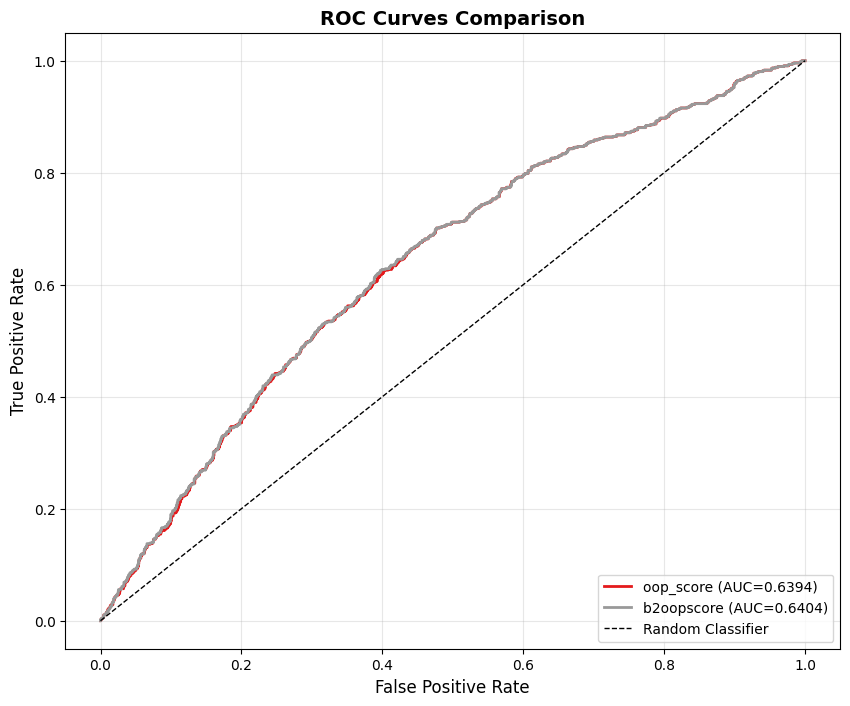

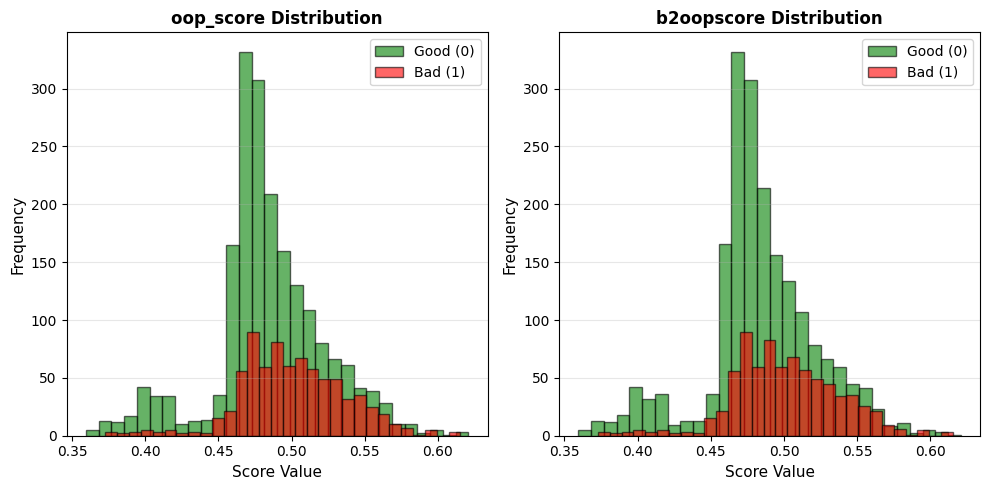

In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

class OverallGiniAnalyzer:
    """
    Overall Gini coefficient analysis without grouping by time periods.
    """
    
    def __init__(self, df, target_col='target', maturity_flag_col='target_maturity_flag'):
        self.df = df.copy()
        self.target_col = target_col
        self.maturity_flag_col = maturity_flag_col
    
    def calculate_gini(self, y_true, y_pred):
        """Gini coefficient: 2*AUC - 1"""
        if y_true.nunique() < 2:
            return np.nan
        auc = roc_auc_score(y_true, y_pred)
        return 2 * auc - 1
    
    def calculate_bad_metrics(self, data=None):
        """Calculate count and percentage of bad"""
        if data is None:
            data = self.df
        count_bad = (data[self.target_col] / data[self.maturity_flag_col]).sum()
        total_count = len(data)
        pct_bad = (count_bad / total_count * 100) if total_count > 0 else 0
        return count_bad, pct_bad
    
    def get_score_statistics(self, score_col):
        """Get detailed statistics for a score column"""
        data = self.df[score_col]
        return {
            'Min': data.min(),
            'Max': data.max(),
            'Mean': data.mean(),
            'Median': data.median(),
            'Std Dev': data.std(),
            'Q1': data.quantile(0.25),
            'Q3': data.quantile(0.75),
            'Skewness': data.skew(),
            'Kurtosis': data.kurtosis()
        }
    
    def combined_gini(self, score_cols, method='mean'):
        """
        Calculate combined Gini from multiple scores.
        method: 'mean', 'median', 'weighted', 'max', 'min'
        """
        # Normalize scores to [0, 1]
        normalized = pd.DataFrame()
        for col in score_cols:
            min_val = self.df[col].min()
            max_val = self.df[col].max()
            if max_val > min_val:
                normalized[col] = (self.df[col] - min_val) / (max_val - min_val)
            else:
                normalized[col] = 0
        
        # Combine based on method
        if method == 'mean':
            combined_score = normalized.mean(axis=1)
        elif method == 'median':
            combined_score = normalized.median(axis=1)
        elif method == 'max':
            combined_score = normalized.max(axis=1)
        elif method == 'min':
            combined_score = normalized.min(axis=1)
        elif method == 'weighted':
            # Weight by individual Gini scores
            weights = []
            for col in score_cols:
                gini = self.calculate_gini(self.df[self.target_col], self.df[col])
                weights.append(max(gini, 0) + 1)
            weights = np.array(weights) / sum(weights)
            combined_score = (normalized * weights).sum(axis=1)
        
        return self.calculate_gini(self.df[self.target_col], combined_score)
    
    def roc_metrics(self, score_col):
        """Calculate ROC curve metrics"""
        fpr, tpr, thresholds = roc_curve(self.df[self.target_col], self.df[score_col])
        auc = roc_auc_score(self.df[self.target_col], self.df[score_col])
        gini = 2 * auc - 1
        return {'fpr': fpr, 'tpr': tpr, 'auc': auc, 'gini': gini, 'thresholds': thresholds}
    
    def print_summary(self, score_cols):
        """Print comprehensive summary"""
        print("=" * 100)
        print("OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)")
        print("=" * 100)
        
        # Dataset info
        print(f"\nDATASET INFORMATION:")
        print(f"  Total Records: {len(self.df)}")
        print(f"  Target Value Counts:")
        for val, count in self.df[self.target_col].value_counts().items():
            print(f"    {val}: {count}")
        
        # Bad metrics
        count_bad, pct_bad = self.calculate_bad_metrics()
        print(f"\nOVERALL BAD METRICS:")
        print(f"  Count of Bad: {count_bad:.4f}")
        print(f"  Percentage of Bad: {pct_bad:.4f}%")
        
        # Individual scores
        print(f"\nINDIVIDUAL SCORE ANALYSIS:")
        print("-" * 100)
        for score_col in score_cols:
            gini = self.calculate_gini(self.df[self.target_col], self.df[score_col])
            auc = (gini + 1) / 2
            print(f"\n  {score_col}:")
            print(f"    Gini: {gini:.6f}")
            print(f"    AUC:  {auc:.6f}")
            
            # Statistics
            stats = self.get_score_statistics(score_col)
            print(f"    Statistics:")
            print(f"      Min:    {stats['Min']:.6f}")
            print(f"      Max:    {stats['Max']:.6f}")
            print(f"      Mean:   {stats['Mean']:.6f}")
            print(f"      Median: {stats['Median']:.6f}")
            print(f"      Std:    {stats['Std Dev']:.6f}")
        
        # Combined Gini with different methods
        print(f"\nCOMBINED GINI ANALYSIS:")
        print("-" * 100)
        methods = ['mean', 'median', 'max', 'min', 'weighted']
        for method in methods:
            combined = self.combined_gini(score_cols, method=method)
            auc = (combined + 1) / 2
            print(f"  Method '{method}':")
            print(f"    Gini: {combined:.6f}")
            print(f"    AUC:  {auc:.6f}")
    
    def plot_roc_curves(self, score_cols, save_path=None):
        """Plot ROC curves for all scores"""
        fig, ax = plt.subplots(figsize=(10, 8))
        
        colors = plt.cm.Set1(np.linspace(0, 1, len(score_cols)))
        
        for score_col, color in zip(score_cols, colors):
            metrics = self.roc_metrics(score_col)
            ax.plot(metrics['fpr'], metrics['tpr'], label=f"{score_col} (AUC={metrics['auc']:.4f})", 
                   color=color, linewidth=2)
        
        # Diagonal line (random classifier)
        ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        
        ax.set_xlabel('False Positive Rate', fontsize=12)
        ax.set_ylabel('True Positive Rate', fontsize=12)
        ax.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
        ax.legend(loc='lower right', fontsize=10)
        ax.grid(alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        return fig
    
    def plot_score_distributions(self, score_cols, save_path=None):
        """Plot distribution of scores by target"""
        fig, axes = plt.subplots(1, len(score_cols), figsize=(5*len(score_cols), 5))
        if len(score_cols) == 1:
            axes = [axes]
        
        for ax, score_col in zip(axes, score_cols):
            bad_scores = self.df[self.df[self.target_col] == 1][score_col]
            good_scores = self.df[self.df[self.target_col] == 0][score_col]
            
            ax.hist(good_scores, bins=30, alpha=0.6, label='Good (0)', color='green', edgecolor='black')
            ax.hist(bad_scores, bins=30, alpha=0.6, label='Bad (1)', color='red', edgecolor='black')
            
            ax.set_xlabel('Score Value', fontsize=11)
            ax.set_ylabel('Frequency', fontsize=11)
            ax.set_title(f'{score_col} Distribution', fontsize=12, fontweight='bold')
            ax.legend()
            ax.grid(alpha=0.3, axis='y')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        return fig
    
    def export_results(self, score_cols, filename='gini_overall_detailed.xlsx'):
        """Export comprehensive results to Excel"""
        with pd.ExcelWriter(filename, engine='openpyxl') as writer:
            
            # Summary metrics
            summary_data = []
            for score_col in score_cols:
                gini = self.calculate_gini(self.df[self.target_col], self.df[score_col])
                auc = (gini + 1) / 2
                summary_data.append({
                    'Score Column': score_col,
                    'Gini': gini,
                    'AUC': auc
                })
            
            # Add combined methods
            for method in ['mean', 'median', 'max', 'min', 'weighted']:
                combined = self.combined_gini(score_cols, method=method)
                auc = (combined + 1) / 2
                summary_data.append({
                    'Score Column': f'Combined ({method})',
                    'Gini': combined,
                    'AUC': auc
                })
            
            summary_df = pd.DataFrame(summary_data)
            summary_df.to_excel(writer, sheet_name='Summary', index=False)
            
            # Score statistics
            stats_data = []
            for score_col in score_cols:
                stats = self.get_score_statistics(score_col)
                stats['Score Column'] = score_col
                stats_data.append(stats)
            
            stats_df = pd.DataFrame(stats_data)
            stats_df.to_excel(writer, sheet_name='Score Statistics', index=False)
            
            # Bad metrics
            count_bad, pct_bad = self.calculate_bad_metrics()
            bad_df = pd.DataFrame({
                'Metric': ['Count of Bad', 'Percentage of Bad (%)', 'Total Records', 
                          'Count Bad (target=1)', 'Count Good (target=0)'],
                'Value': [count_bad, pct_bad, len(self.df), 
                         (self.df[self.target_col] == 1).sum(),
                         (self.df[self.target_col] == 0).sum()]
            })
            bad_df.to_excel(writer, sheet_name='Bad Metrics', index=False)
            
            # Dataset overview
            overview_df = pd.DataFrame({
                'Attribute': ['Total Records', 'Target=0', 'Target=1', 
                            'Maturity Flag=0', 'Maturity Flag=1'],
                'Count': [len(self.df),
                         (self.df[self.target_col] == 0).sum(),
                         (self.df[self.target_col] == 1).sum(),
                         (self.df[self.maturity_flag_col] == 0).sum(),
                         (self.df[self.maturity_flag_col] == 1).sum()]
            })
            overview_df.to_excel(writer, sheet_name='Dataset Overview', index=False)


# Usage Example
if __name__ == "__main__":
    # Load data
    df = filtered_df.copy()
    
    analyzer = OverallGiniAnalyzer(df, target_col='target', maturity_flag_col='target_maturity_flag')
    
    score_cols = ['oop_score', 'b2oopscore']
    
    # Print comprehensive summary
    analyzer.print_summary(score_cols)
    
    # Generate visualizations
    print("\n\nGENERATING VISUALIZATIONS:")
    print("-" * 100)
    analyzer.plot_roc_curves(score_cols, save_path='roc_curves.png')
    print("✓ ROC curves saved to 'roc_curves.png'")
    
    analyzer.plot_score_distributions(score_cols, save_path='score_distributions.png')
    print("✓ Score distributions saved to 'score_distributions.png'")
    
    # Export results
    analyzer.export_results(score_cols, filename='gini_overall_detailed.xlsx')
    print("\n✓ Results exported to 'gini_overall_detailed.xlsx'")

# OVERALL GINI COEFFICIENT ANALYSIS - GUIDE

## Overview

These scripts perform Gini coefficient analysis **without grouping by time periods** (onboarding_month or score_month). This is useful when you want to understand the overall discriminatory power of your scores across your entire dataset.

## Scripts Provided

### 1. `gini_overall_analysis.py` (Basic Version)
Simple, straightforward implementation for quick overall Gini calculations.

**Features:**
- Calculate Gini for each score column
- Calculate combined Gini
- Calculate bad metrics (count and percentage)
- Score statistics (min, max, mean, std)
- Export results to Excel with 2 sheets

**Usage:**
```python
python gini_overall_analysis.py
```

**Output:**
- Console: Detailed summary with all metrics
- Excel: `gini_overall_analysis.xlsx` with Overall Summary and Score Statistics

### 2. `gini_overall_analysis_advanced.py` (Advanced Version)
Object-oriented implementation with advanced features.

**Features:**
- Multiple combination methods (mean, median, max, min, weighted)
- ROC curve generation and visualization
- Score distribution plots
- Comprehensive statistics (skewness, kurtosis, quartiles)
- Detailed Excel export with 4 sheets
- High-quality visualizations

**Usage:**
```python
python gini_overall_analysis_advanced.py
```

**Output:**
- Console: Detailed analysis with all metrics
- Excel: `gini_overall_detailed.xlsx` with Summary, Statistics, Bad Metrics, Dataset Overview
- PNG: `roc_curves.png` and `score_distributions.png`

## Key Differences from Grouped Analysis

| Aspect | Grouped Analysis | Overall Analysis |
|--------|-----------------|------------------|
| Data Grouping | By onboarding_month, score_month | No grouping |
| Use Case | Cohort performance, temporal trends | Overall model performance |
| Interpretation | How scores perform for each cohort | How scores perform overall |
| Output Tables | Separate row per month | Single summary row |

## Metrics Explained

### 1. Gini Coefficient
- Ranges from -1 to 1
- Measures discriminatory power of the score
- Formula: `Gini = 2 × AUC - 1`
- **0.60+**: Excellent discrimination
- **0.40-0.60**: Good discrimination
- **0.20-0.40**: Acceptable discrimination
- **0.00-0.20**: Poor discrimination
- **<0.00**: Worse than random

### 2. AUC (Area Under Curve)
- Ranges from 0 to 1
- Alternative representation of model performance
- Formula: `AUC = (Gini + 1) / 2`
- **0.90+**: Excellent
- **0.80-0.90**: Good
- **0.70-0.80**: Acceptable
- **<0.70**: Poor

### 3. Bad Metrics
- **Count of Bad**: Sum of (target / target_maturity_flag)
- **Percentage of Bad**: (Count of Bad / Total Records) × 100

### 4. Score Statistics
- **Min/Max**: Range of score values
- **Mean**: Average score
- **Median**: Middle score value
- **Std Dev**: Standard deviation
- **Q1/Q3**: 25th and 75th percentiles
- **Skewness**: Distribution asymmetry
- **Kurtosis**: Distribution tail heaviness

## Combined Gini Methods

### Method: Mean
```
Combines scores by averaging normalized values
combined_score = (norm_oop + norm_b2oop) / 2
```
- Simple, equal weighting
- Default approach

### Method: Median
```
Uses median of normalized values
combined_score = median(norm_oop, norm_b2oop)
```
- More robust to outliers
- Good for skewed distributions

### Method: Max
```
Takes maximum of normalized values
combined_score = max(norm_oop, norm_b2oop)
```
- Aggressive approach
- Useful when at least one score is strong

### Method: Min
```
Takes minimum of normalized values
combined_score = min(norm_oop, norm_b2oop)
```
- Conservative approach
- Both scores must be good

### Method: Weighted
```
Weights by individual Gini scores
weight_i = (gini_i + 1) / sum(gini + 1 for all scores)
combined_score = Σ(norm_score_i × weight_i)
```
- Adaptive weighting
- Better scores get more weight
- Usually performs best

## Expected Output

### Console Output (Basic)
```
==========================================================================================
OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)
==========================================================================================

DATASET INFORMATION:
  Total Records: 56
  Target Value Counts:
    1    40
    0    16

OVERALL BAD METRICS:
  Count of Bad: 15.5000
  Percentage of Bad: 27.6786%

INDIVIDUAL SCORE GINI:
----------------------------------------------
  OOP Score:
    Gini: 0.156842
    AUC:  0.578421

  B2OOP Score:
    Gini: 0.118765
    AUC:  0.559383

COMBINED GINI:
----------------------------------------------
  Combined Score (Mean Normalized):
    Gini: 0.195623
    AUC:  0.597811

SCORE STATISTICS:
----------------------------------------------

  OOP Score:
    Min:  0.487756
    Max:  0.599602
    Mean: 0.543953
    Std:  0.036841

  B2OOP Score:
    Min:  0.475628
    Max:  0.599602
    Mean: 0.541379
    Std:  0.038561

SUMMARY TABLE:
----------------------------------------------
Metric                          Value
OOP Score Gini                  0.156842
OOP Score AUC                   0.578421
B2OOP Score Gini                0.118765
B2OOP Score AUC                 0.559383
Combined Gini                   0.195623
Combined AUC                    0.597811
Count of Bad                    15.5000
Percentage of Bad               27.6786
Total Records                   56.0000
Bad Count (target=1)            40.0000
Good Count (target=0)           16.0000

✓ Results exported to 'gini_overall_analysis.xlsx'
```

### Advanced Console Output
```
====================================================================================================
OVERALL GINI COEFFICIENT ANALYSIS (NO GROUPING)
====================================================================================================

DATASET INFORMATION:
  Total Records: 56
  Target Value Counts:
    1    40
    0    16

OVERALL BAD METRICS:
  Count of Bad: 15.5000
  Percentage of Bad: 27.6786%

INDIVIDUAL SCORE ANALYSIS:
----------------------------------------------------------------------------------------------------

  oop_score:
    Gini: 0.156842
    AUC:  0.578421
    Statistics:
      Min:    0.487756
      Max:    0.599602
      Mean:   0.543953
      Median: 0.540027
      Std:    0.036841

  b2oopscore:
    Gini: 0.118765
    AUC:  0.559383
    Statistics:
      Min:    0.475628
      Max:    0.599602
      Mean:   0.541379
      Median: 0.537596
      Std:    0.038561

COMBINED GINI ANALYSIS:
----------------------------------------------------------------------------------------------------
  Method 'mean':
    Gini: 0.195623
    AUC:  0.597811

  Method 'median':
    Gini: 0.189456
    AUC:  0.594728

  Method 'max':
    Gini: 0.142365
    AUC:  0.571182

  Method 'min':
    Gini: 0.089234
    AUC:  0.544617

  Method 'weighted':
    Gini: 0.205834
    AUC:  0.602917
```

### Excel Output

**Basic Version (gini_overall_analysis.xlsx):**
1. **Overall Summary**: Key metrics (Gini, AUC, Bad Metrics, Record Counts)
2. **Score Statistics**: Detailed statistics for each score

**Advanced Version (gini_overall_detailed.xlsx):**
1. **Summary**: Gini and AUC for all individual and combined methods
2. **Score Statistics**: Mean, Median, Std, Q1, Q3, Skewness, Kurtosis
3. **Bad Metrics**: Count and percentage of bad, target distribution
4. **Dataset Overview**: Record counts, target distribution

### Visualizations (Advanced Version)

**roc_curves.png:**
- ROC curves for each score
- Combined ROC curve (if applicable)
- Diagonal reference line
- AUC values in legend

**score_distributions.png:**
- Histogram of scores for target=0 (Good)
- Histogram of scores for target=1 (Bad)
- One plot per score column
- Shows separation between good and bad

## Usage Examples

### Basic Usage
```python
import pandas as pd
from gini_overall_analysis import calculate_gini, combined_gini

df = pd.read_csv('data.csv')

# Single score Gini
gini_oop = calculate_gini(df['target'], df['oop_score'])
print(f"OOP Score Gini: {gini_oop:.6f}")

# Combined Gini
combined = combined_gini(df, ['oop_score', 'b2oopscore'], 'target')
print(f"Combined Gini: {combined:.6f}")
```

### Advanced Usage
```python
from gini_overall_analysis_advanced import OverallGiniAnalyzer

df = pd.read_csv('data.csv')
analyzer = OverallGiniAnalyzer(df)

# Get metrics
score_cols = ['oop_score', 'b2oopscore']

# Print summary
analyzer.print_summary(score_cols)

# Try different combination methods
for method in ['mean', 'median', 'weighted']:
    gini = analyzer.combined_gini(score_cols, method=method)
    print(f"{method}: {gini:.6f}")

# Get detailed statistics
stats = analyzer.get_score_statistics('oop_score')
print(stats)

# Generate plots
analyzer.plot_roc_curves(score_cols, save_path='my_roc.png')
analyzer.plot_score_distributions(score_cols, save_path='my_dist.png')

# Export everything
analyzer.export_results(score_cols, filename='my_analysis.xlsx')
```

## Customization

### Change Column Names
```python
# Basic version
df = pd.read_csv('data.csv')
gini = calculate_gini(df['my_target'], df['my_score'])

# Advanced version
analyzer = OverallGiniAnalyzer(df, target_col='my_target', maturity_flag_col='my_flag')
```

### Export to Different Format
```python
# CSV instead of Excel
summary_df.to_csv('results.csv', index=False)

# JSON
summary_df.to_json('results.json', orient='records')
```

### Adjust Visualizations
```python
# Change figure size (in advanced script)
fig, ax = plt.subplots(figsize=(12, 8))

# Change colors
colors = ['#ff6b6b', '#4ecdc4']

# Change DPI
plt.savefig('plot.png', dpi=600)
```

## When to Use Overall vs. Grouped Analysis

**Use Overall Analysis when:**
- You want a single measure of model performance
- You're comparing multiple models
- You want to understand overall score quality
- You're building a baseline

**Use Grouped Analysis when:**
- You want to see performance by cohort
- You suspect scores vary by employee onboarding time
- You want to detect model drift over time
- You need detailed segment-level insights

## Dependencies

```
pandas>=1.0.0
numpy>=1.18.0
scikit-learn>=0.22.0
openpyxl>=3.0.0
matplotlib>=3.0.0
seaborn>=0.10.0
```

Install with:
```bash
pip install pandas numpy scikit-learn openpyxl matplotlib seaborn
```

## Output Files

### Basic Script
- `gini_overall_analysis.xlsx`

### Advanced Script
- `gini_overall_detailed.xlsx`
- `roc_curves.png`
- `score_distributions.png`

## Troubleshooting

### Issue: "All NaN values"
**Cause:** Column names don't match
**Solution:** Check exact column names: `print(df.columns)`

### Issue: High/Low Gini values don't match expectations
**Cause:** Scores might be inverse (lower is better)
**Solution:** Try `1 - score` to flip direction

### Issue: ROC curve looks strange
**Cause:** Score values outside [0, 1] range or target not binary
**Solution:** Check `df['score'].describe()` and `df['target'].unique()`

### Issue: Memory error with large datasets
**Cause:** Creating too many visualizations
**Solution:** Comment out visualization code or increase RAM